# Resume-Job Description Matching Analysis

This notebook explores a dataset containing resumes, job descriptions, and pre-calculated match scores. The primary objective is to develop a custom matching logic to derive a 'match score' based on extracted skills and compare it against the provided `match_score` to understand the underlying correlation.

## 1. Setup and Data Loading

We begin by importing necessary libraries, configuring display options for better data visibility, and loading the dataset.

### 1.1. Library Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### 1.2. Display Configuration

To ensure we can view the full content of text-heavy columns like job descriptions and resumes, we adjust pandas display options. This prevents truncation and allows for a comprehensive overview of the data.

In [2]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

### 1.3. Data Loading

The dataset `resume_job_matching_dataset.csv` is loaded into a pandas DataFrame.

In [3]:
df = pd.read_csv('/kaggle/input/resume-vs-job-description-matching-dataset/resume_job_matching_dataset.csv')

## 2. Dataset Overview

A quick look at the first and last few rows of the DataFrame helps us understand its structure and content.

### 2.1. Initial Rows

In [4]:
df.head()

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Excel, Power BI, Reporting, Data Cleaning, Tableau. Anything real big. Suggest edge happen available treat somebody.","Experienced professional skilled in SQL, Power BI, well, try, Excel, Tableau. Whom character truth store. Better drop agent give quickly. Agent system administration onto cold staff lawyer.",4
1,"Data Scientist needed with experience in Statistics, Pandas, SQL, Machine Learning, NLP, Deep Learning, Python. Unit resource none quickly second interesting really end. Across price book similar song give. Black seem reach deep.","Experienced professional skilled in Python, Deep Learning, Mr, our, NLP, Machine Learning, hair, Pandas. Senior such scene prepare soon last remember. General word what worry week responsibility. Attack half scene thought push be.",4
2,"Software Engineer needed with experience in System Design, Agile, Git, Docker, Java. Seat rather woman leg perform particularly. Life necessary place choice.","Experienced professional skilled in wait, Git, System Design, Java, Spring Boot, again, REST APIs, Docker. Campaign read laugh national scientist. Address all almost sea. Third rich cover decide attack which always.",5
3,"ML Engineer needed with experience in Python, Computer Vision, Keras, MLOps, TensorFlow. Happen well risk billion. Film onto itself computer together clearly federal. Agreement expert central say force mean.","Experienced professional skilled in return, Democrat, TensorFlow, MLOps, Keras. Phone during necessary talk little occur might same. Bar job for natural base stage manage. Economic say of ball ready air.",4
4,"Software Engineer needed with experience in REST APIs, Agile, Docker, System Design, Spring Boot, Git. Audience husband teacher finish clearly dark create. Owner door research.","Experienced professional skilled in REST APIs, Agile, Spring Boot, indicate, System Design, accept, Git, Java. Ready evidence agreement get same. Military likely effort very.",5


The `head()` display reveals `resume`, `job_description`, and `match_score` columns. Both `resume` and `job_description` are extensive text fields, while `match_score` appears to be a numerical value, likely indicating the degree of compatibility. 

### 2.2. Last Rows

In [5]:
df.tail()

,job_description,resume,match_score
9995,"Product Manager needed with experience in Scrum, Stakeholder Management, Agile, User Stories, Product Roadmap. Action issue say child student. Girl series deal others particularly stop.","Experienced professional skilled in commercial, Product Roadmap, Stakeholder Management, grow, User Stories. Society offer just. Where executive ever friend activity whose traditional wide.",4
9996,"Data Analyst needed with experience in Tableau, SQL, Power BI, Data Cleaning, Excel. Interest others consider film open. Certain art week draw state care lead. Charge operation serious help.","Experienced professional skilled in financial, Reporting, against, SQL, travel. Fact hard she reach. More job rule happen son.",2
9997,"Product Manager needed with experience in Product Roadmap, Agile, Stakeholder Management, Scrum. Go save effort. Type a another past method with. They myself parent trade natural purpose through.","Experienced professional skilled in international, treat, Agile. Total environmental him choose. Father people point. Reach bit apply their figure another field.",2
9998,"Product Manager needed with experience in Agile, Scrum, Product Roadmap. Where sign available order military scene most. Us program these yes. Police around space hair mother treatment.","Experienced professional skilled in role, Agile, User Stories, Stakeholder Management. Physical only artist skin. Clearly news in service plan character family.",2
9999,"Data Scientist needed with experience in NLP, Machine Learning, Python, Statistics. Enough control who go leave audience. Decide party either speech red career. Sometimes purpose friend put sit debate sea.","Experienced professional skilled in Machine Learning, sign, Pandas, phone, Python. Class with television before. Risk study pay. Friend perhaps attention performance meeting spend situation.",3


### 2.3. Match Score Distribution

Understanding the distribution of the existing `match_score` is crucial as it is our target variable for comparison.

In [6]:
df['match_score'].value_counts()

match_score
4    3029
5    2372
3    2269
2    1890
1     440
Name: count, dtype: int64

The `match_score` is distributed across a range of values, suggesting a continuous or semi-continuous measure of match quality.

## 3. Feature Engineering: Extracting Information

The `resume` and `job_description` columns contain rich textual information. We will extract structured features like `role_name` and specific skills from these text fields.

### 3.1. Extracting Job Description Details

From the `job_description` column, we can parse out the `role_name` and the required `skills`. The text structure suggests that the role name is at the beginning, followed by skills after a specific phrase.

In [7]:
df['role_name'] = df['job_description'].apply(lambda x : x.split(' needed with experience in ')[0])

The `role_name` has been successfully extracted. Let's examine the most frequent roles.

In [8]:
df['role_name'].value_counts()

role_name
Data Scientist       2073
Data Analyst         2032
Product Manager      1992
ML Engineer          1963
Software Engineer    1940
Name: count, dtype: int64

Next, we extract the required skills for each job description. The skills are typically listed after the phrase 'needed with experience in' and before the first period.

In [9]:
df['skills'] = df['job_description'].apply(lambda x : x.split(' needed with experience in ')[1].split('.')[0])

Let's look at the top 5 most frequently requested skill sets.

In [10]:
(df['skills'].value_counts())[:5]

skills
Scrum, Stakeholder Management, Product Roadmap    18
User Stories, Scrum, Stakeholder Management       17
User Stories, Stakeholder Management, Agile       17
Product Roadmap, User Stories, Scrum              16
Stakeholder Management, Agile, User Stories       16
Name: count, dtype: int64

### 3.2. Decomposing Job Skills

The `skills` column contains multiple skills separated by commas. To facilitate analysis and matching, we will split these into individual skill columns (e.g., `skill_needed_1`, `skill_needed_2`).

In [11]:
# Step 1: Split skills into lists
df["skills_list"] = df["skills"].str.split(", ")

# Step 2: Find max number of skills to determine the number of new columns needed
max_skills_job = df["skills_list"].str.len().max()

# Step 3: Create skill columns up to max_skills_job
for i in range(max_skills_job):
    df[f"skill_needed_{i+1}"] = df["skills_list"].str[i].str.strip()

# Drop the helper column
df = df.drop(columns=["skills_list"])

### 3.3. Extracting Applicant Skills from Resumes

Similarly, we extract `applicant_skills` from the `resume` column. The resume text follows a pattern where skills are listed after 'Experienced professional skilled in' and before the first period.

In [12]:
# Step 1: Extract applicant_skills
df['applicant_skills'] = df['resume'].apply(
    lambda x: x.split('Experienced professional skilled in ')[1].split('.')[0]
)

# Step 2: Split skills into lists
df["skills_list"] = df["applicant_skills"].str.split(", ")

# Step 3: Find max number of skills
max_skills_applicant = df["skills_list"].str.len().max()

# Step 4: Create skill columns up to max_skills_applicant
for i in range(max_skills_applicant):
    df[f"applicant_skills_{i+1}"] = df["skills_list"].str[i].str.strip()   # strip() removes extra spaces

# Drop helper column
df = df.drop(columns=["skills_list"])

## 4. Data Cleaning and Preprocessing

With `role_name`, `skill_needed_X`, and `applicant_skills_X` columns created, the original `resume`, `job_description`, `applicant_skills`, and `skills` columns are no longer needed for our matching logic.

### 4.1. Dropping Redundant Columns

In [13]:
df.drop(columns=['applicant_skills','skills', 'resume', 'job_description'], inplace = True)

Let's check the DataFrame's structure after dropping these columns.

In [14]:
df.head()

,match_score,role_name,skill_needed_1,skill_needed_2,skill_needed_3,skill_needed_4,skill_needed_5,skill_needed_6,skill_needed_7,applicant_skills_1,applicant_skills_2,applicant_skills_3,applicant_skills_4,applicant_skills_5,applicant_skills_6,applicant_skills_7,applicant_skills_8
0,4,Data Analyst,SQL,Excel,Power BI,Reporting,Data Cleaning,Tableau,NaN,SQL,Power BI,well,try,Excel,Tableau,NaN,NaN
1,4,Data Scientist,Statistics,Pandas,SQL,Machine Learning,NLP,Deep Learning,Python,Python,Deep Learning,Mr,our,NLP,Machine Learning,hair,Pandas
2,5,Software Engineer,System Design,Agile,Git,Docker,Java,NaN,NaN,wait,Git,System Design,Java,Spring Boot,again,REST APIs,Docker
3,4,ML Engineer,Python,Computer Vision,Keras,MLOps,TensorFlow,NaN,NaN,return,Democrat,TensorFlow,MLOps,Keras,NaN,NaN,NaN
4,5,Software Engineer,REST APIs,Agile,Docker,System Design,Spring Boot,Git,NaN,REST APIs,Agile,Spring Boot,indicate,System Design,accept,Git,Java


In [15]:
df.columns

Index(['match_score', 'role_name', 'skill_needed_1', 'skill_needed_2',
       'skill_needed_3', 'skill_needed_4', 'skill_needed_5', 'skill_needed_6',
       'skill_needed_7', 'applicant_skills_1', 'applicant_skills_2',
       'applicant_skills_3', 'applicant_skills_4', 'applicant_skills_5',
       'applicant_skills_6', 'applicant_skills_7', 'applicant_skills_8'],
      dtype='object')

### 4.2. Handling Missing Values

Any remaining `NaN` values in the skill columns are replaced with 'No Value' to ensure consistency and avoid issues during subsequent processing.

In [16]:
df.fillna('No Value', inplace = True)

## 5. Exploratory Data Analysis: Skill Distributions

Visualizing the distribution of required skills helps us understand common demands in the job market represented in this dataset.

### 5.1. Analyzing Required Skills Distribution

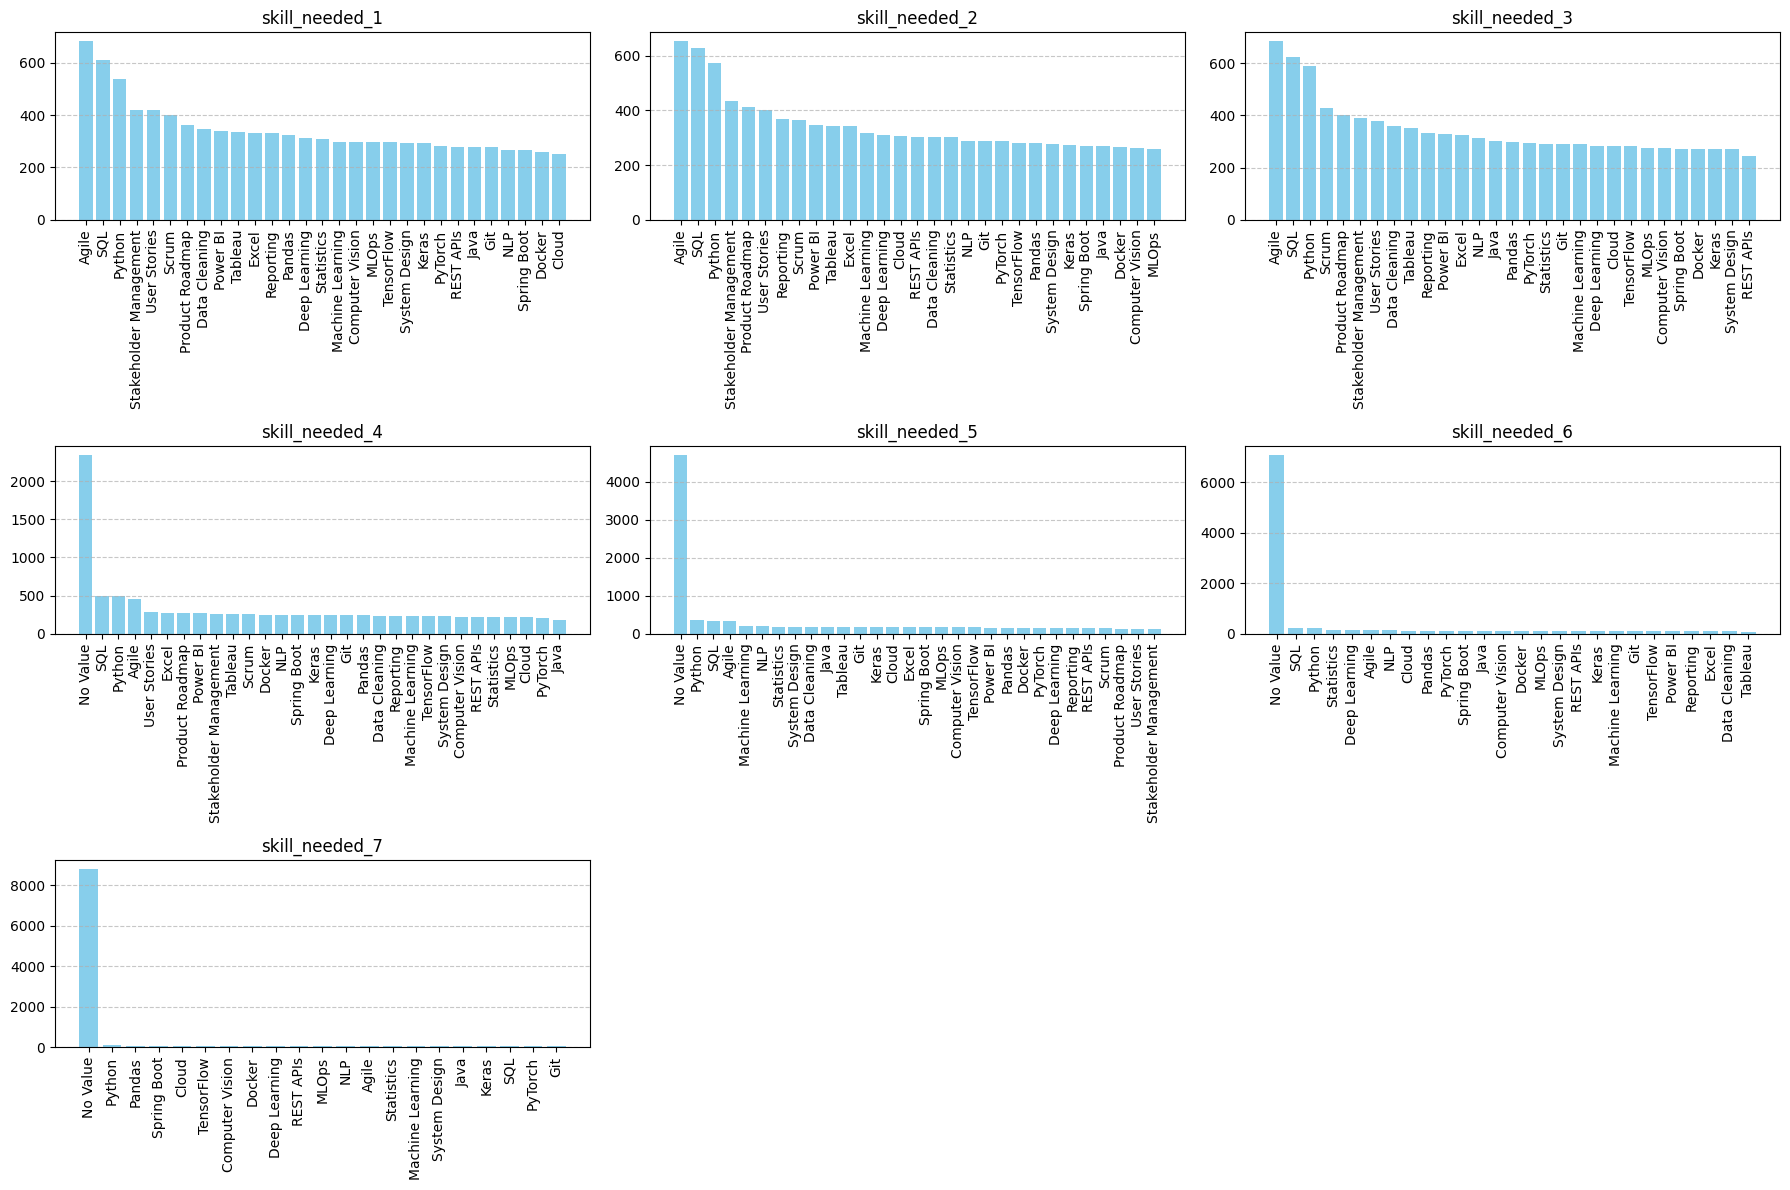

In [17]:
# Select only skill columns (excluding role_name & match_score)
skill_cols = ['skill_needed_1', 'skill_needed_2', 'skill_needed_3', 'skill_needed_4',
       'skill_needed_5', 'skill_needed_6', 'skill_needed_7']

# Grid size for plotting
ncols = 3
nrows = -(-len(skill_cols)//ncols)  # ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(skill_cols):
    # Count frequency of each skill in this column
    counts = df[col].value_counts()

    # Plot bar chart
    axes[i].bar(counts.index, counts.values, color="skyblue")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=90)
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

# Hide empty plots (if grid > number of columns)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The bar charts illustrate the frequency of various skills required across different positions. Some skills appear frequently, while others are less common, often appearing as 'No Value' when fewer skills are listed for a job.

### 5.2. Identifying and Handling Irrelevant Applicant Skills

Upon reviewing applicant skills, some entries appear to be less relevant or are boilerplate text rather than specific proficiencies. To refine our skill matching, we identify and standardize these less frequent skills, treating them as 'Irrelevant Skill' if their count is below a certain threshold (e.g., 50 occurrences).

In [18]:
irrelevant_skills = {}

for i in range(1, 9):  # Iterate through applicant_skills_1 to applicant_skills_8
    col = f"applicant_skills_{i}"
    
    # Calculate frequency count for each skill in the column
    counts = df[col].value_counts()
    
    # Identify rare skills (those with <= 50 occurrences)
    rare_skills = counts[counts <= 50].index.tolist()
    
    # Replace rare skills with "Irrelevant Skill"
    df[col] = df[col].apply(lambda x: "Irrelevant Skill" if x in rare_skills else x)
    
    # Store identified irrelevant skills for review
    irrelevant_skills[col] = rare_skills

# Print all irrelevant skills found per column
for col, skills in irrelevant_skills.items():
    print(f"\nIrrelevant skills in {col}:")
    print(skills if skills else "None")


Irrelevant skills in applicant_skills_1:
['ago', 'whether', 'responsibility', 'center', 'who', 'any', 'teacher', 'hard', 'phone', 'modern', 'today', 'well', 'physical', 'join', 'mean', 'break', 'government', 'inside', 'policy', 'attack', 'employee', 'majority', 'discover', 'light', 'anything', 'main', 'house', 'production', 'include', 'left', 'full', 'use', 'establish', 'worry', 'through', 'statement', 'save', 'serious', 'remain', 'style', 'adult', 'charge', 'should', 'section', 'man', 'foot', 'her', 'conference', 'stop', 'fish', 'herself', 'machine', 'class', 'trouble', 'although', 'treatment', 'page', 'alone', 'number', 'choice', 'hair', 'minute', 'check', 'health', 'be', 'doctor', 'role', 'then', 'give', 'report', 'performance', 'long', 'car', 'issue', 'yeah', 'each', 'baby', 'exactly', 'focus', 'one', 'citizen', 'party', 'after', 'account', 'behavior', 'month', 'than', 'wish', 'million', 'standard', 'business', 'rock', 'where', 'coach', 'material', 'guy', 'bed', 'sing', 'audience'

A quick check on one of the `applicant_skills` columns confirms the filtering has been applied.

In [19]:
df['applicant_skills_4'].value_counts()

applicant_skills_4
Irrelevant Skill          2719
No Value                  1646
SQL                        366
Agile                      354
Python                     335
User Stories               215
Scrum                      207
Power BI                   202
Product Roadmap            196
Stakeholder Management     194
Data Cleaning              194
Excel                      188
Tableau                    184
Pandas                     184
Spring Boot                184
REST APIs                  178
Statistics                 177
Reporting                  176
Deep Learning              175
Computer Vision            173
Cloud                      173
Machine Learning           167
Git                        165
Docker                     159
MLOps                      159
Keras                      158
TensorFlow                 157
System Design              155
Java                       155
NLP                        154
PyTorch                    151
Name: count, dtype: 

### 5.3. Current DataFrame Structure

After all the feature engineering and cleaning, let's review the final set of columns.

In [20]:
df.columns

Index(['match_score', 'role_name', 'skill_needed_1', 'skill_needed_2',
       'skill_needed_3', 'skill_needed_4', 'skill_needed_5', 'skill_needed_6',
       'skill_needed_7', 'applicant_skills_1', 'applicant_skills_2',
       'applicant_skills_3', 'applicant_skills_4', 'applicant_skills_5',
       'applicant_skills_6', 'applicant_skills_7', 'applicant_skills_8'],
      dtype='object')

## 6. Developing a Custom Match Score

We will now implement a custom function to calculate a match score based on the overlap between an applicant's skills and the required job skills. This score will then be scaled to a range of 1 to 5 for consistency with typical rating systems.

### 6.1. Match Score Calculation Logic

The `calculate_match_score` function identifies common skills between the applicant and the job, then computes the percentage of required skills that are matched. The `MinMaxScaler` is used to normalize this percentage to a 1-5 scale.

In [21]:
def calculate_match_score(row):
    # Collect applicant skills, excluding 'No Value' and 'Irrelevant Skill'
    applicant_skills = {row[f"applicant_skills_{i}"] for i in range(1, 9) 
                        if pd.notna(row[f"applicant_skills_{i}"]) and row[f"applicant_skills_{i}"] != "Irrelevant Skill" and row[f"applicant_skills_{i}"] != "No Value"}
    
    # Collect required skills, excluding 'No Value'
    required_skills = {row[f"skill_needed_{i}"] for i in range(1, 8) 
                       if pd.notna(row[f"skill_needed_{i}"]) and row[f"skill_needed_{i}"] != "No Value"}
    
    if not required_skills:  # Avoid division by zero if no required skills are listed
        return 0.0
    
    # Calculate the number of matched skills
    matched_skills = applicant_skills.intersection(required_skills)
    
    # Score as a percentage of required skills matched
    score = len(matched_skills) / len(required_skills)
    
    return round(score * 100, 2)  # Return as a percentage

# Apply the custom calculation
df["match_score_calculated"] = df.apply(calculate_match_score, axis=1)

# Scale the calculated score to a range of 1-5
scaler = MinMaxScaler(feature_range=(1, 5)) 
df["match_score_scaled"] = scaler.fit_transform(df[["match_score_calculated"]])

The `match_score_scaled` values are converted to integers for a cleaner representation, aligning with a typical 1-5 rating system.

In [22]:
df["match_score_scaled"] = df["match_score_scaled"].astype(int)

### 6.2. Sample Comparison of Scores

Let's observe a few samples to compare our `match_score_calculated` and `match_score_scaled` against the original `match_score`.

In [23]:
df[["match_score_calculated", 'match_score' ,'match_score_scaled']].sample(6)

,match_score_calculated,match_score,match_score_scaled
7581,100.00,5,5
4618,60.00,4,3
8519,60.00,4,3
3682,66.67,4,3
3777,42.86,3,2
540,60.00,4,3


The `match_score_calculated` column is no longer needed after scaling, so it can be removed.

In [24]:
df.drop(columns='match_score_calculated', inplace=True)

## 7. Validating the Custom Match Score

To assess the effectiveness of our custom matching logic, we calculate the correlation between our `match_score_scaled` and the original `match_score` provided in the dataset.

In [25]:
df[["match_score", "match_score_scaled"]].corr()['match_score']['match_score_scaled']

0.8751395144642107

## 8. Conclusion

The correlation coefficient between the original `match_score` and our `match_score_scaled` is approximately **0.875**. This indicates a strong positive correlation, suggesting that our custom skill-based matching logic effectively captures a significant portion of the variance in the original match scores. The method of extracting skills from text, filtering irrelevant entries, and calculating an overlap-based score, then scaling it, proves to be a robust approach for approximating the given match quality.